# Linear Regression Model Training
### Read in features and labels
### Do some multivariate linear regression
### See how good the fits are
### Make some plots of the final WhereSIOUS scores & print some stats

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats.stats import pearsonr
from sklearn import cross_validation

%matplotlib inline

In [2]:
# save min/max of business age
bus_age_min = 0.243835616438
bus_age_max = 18.7589041096

# read in features and labels/examples (see build_features_labels2.ipynb for more info)
features = pd.read_csv('data_final/features.csv')
print features.shape
print features.columns
features[-100:]

(313, 50)
Index([u'census_tract', u'bus_age', u'n_business', u'n_businesses_11',
       u'n_businesses_21', u'n_businesses_22', u'n_businesses_23',
       u'n_businesses_31', u'n_businesses_32', u'n_businesses_33',
       u'n_businesses_42', u'n_businesses_44', u'n_businesses_45',
       u'n_businesses_48', u'n_businesses_49', u'n_businesses_51',
       u'n_businesses_52', u'n_businesses_53', u'n_businesses_54',
       u'n_businesses_55', u'n_businesses_56', u'n_businesses_61',
       u'n_businesses_62', u'n_businesses_71', u'n_businesses_72',
       u'n_businesses_81', u'n_businesses_92', u'population',
       u'population_percent_male', u'population_percent_female', u'age_med',
       u'age_med_male', u'age_med_female', u'minor_percent', u'adult_percent',
       u'homes', u'homes_percent_mortgage', u'homes_percent_clear',
       u'homes_percent_rent', u'employment_percent', u'income_med',
       u'income_med_owner', u'income_med_renter', u'cost_med',
       u'cost_med_owner', u'cost_

,census_tract,bus_age,n_business,n_businesses_11,n_businesses_21,n_businesses_22,n_businesses_23,n_businesses_31,n_businesses_32,n_businesses_33,...,income_med,income_med_owner,income_med_renter,cost_med,cost_med_owner,cost_med_renter,walk_score,transit_score,bike_score,total_amount
213,9306,0.430601,0.068598,0.00,0.0,0.000,0.016216,0.000000,0.075,0.006757,...,0.439137,0.429657,0.316636,0.549892,0.55450,0.9370,0.391753,0.370370,0.500000,0.000000
214,9400,0.217668,0.006402,0.25,0.0,0.000,0.005405,0.000000,0.000,0.006757,...,0.300736,1.000000,0.271830,0.592191,1.00000,1.0000,0.422680,0.259259,0.607143,0.000000
215,9502,0.480764,0.037195,0.50,0.0,0.000,0.010811,0.000000,0.050,0.000000,...,0.427016,0.350271,0.326665,0.460141,0.44875,0.8465,0.288660,0.209877,0.416667,0.000000
216,9504,0.434004,0.046951,0.00,0.0,0.000,0.021622,0.029412,0.050,0.000000,...,0.989962,0.893983,0.309367,0.947939,1.00000,0.7925,0.000000,0.000000,0.000000,0.000000
217,9505,0.525229,0.056402,0.00,0.0,0.000,0.032432,0.000000,0.025,0.006757,...,0.656492,0.549142,0.424106,0.603037,0.61025,0.9660,0.288660,0.209877,0.416667,0.000000
218,9506,0.570435,0.036890,0.50,0.0,0.000,0.027027,0.029412,0.000,0.006757,...,0.599696,0.464473,0.513796,0.556670,0.50500,1.0000,0.288660,0.209877,0.416667,0.000000
219,9507,0.532480,0.028354,0.00,0.0,0.000,0.005405,0.000000,0.025,0.020270,...,0.534927,0.515603,0.464678,0.495119,0.51850,0.9060,0.288660,0.209877,0.416667,0.000000
220,9509,0.531666,0.073171,0.25,0.0,0.000,0.054054,0.029412,0.025,0.013514,...,0.434346,0.557457,0.357717,0.476410,0.44625,0.9080,0.000000,0.000000,0.000000,0.000000
221,9510,0.109796,0.007317,0.00,0.0,0.000,0.005405,0.000000,0.000,0.000000,...,0.313071,0.000000,0.287189,0.598427,0.00000,1.0000,0.288660,0.209877,0.416667,0.000000
222,9511,0.027227,0.002439,0.00,0.0,0.000,0.000000,0.000000,0.000,0.006757,...,0.316004,0.000000,0.289377,0.595445,0.00000,1.0000,0.288660,0.209877,0.416667,0.000000


## Fit w/ all input features (using statsmodels)

In [3]:
# fit the data
#   + to use feature
#   - to remove feature
#   : to multiply 2 features
#   * to multiply 2 features *and* use both individually
#   C(<feature>) to make <feature> into dummy/categorical feature
formula_str = 'bus_age ~ n_business - n_businesses_11 - n_businesses_21 - n_businesses_22 ' \
                '- n_businesses_23 - n_businesses_31 - n_businesses_32 - n_businesses_33 - n_businesses_42 ' \
                '- n_businesses_44 - n_businesses_45 - n_businesses_48 - n_businesses_49 - n_businesses_51 ' \
                '- n_businesses_52 - n_businesses_53 - n_businesses_54 - n_businesses_55 - n_businesses_56 ' \
                '- n_businesses_61 - n_businesses_62 - n_businesses_71 - n_businesses_72 - n_businesses_81 ' \
                '- n_businesses_92 + population - population_percent_male + population_percent_female + age_med ' \
                '- age_med_male - age_med_female - minor_percent + adult_percent + homes - homes_percent_mortgage '\
                '- homes_percent_clear - homes_percent_rent + employment_percent + income_med - income_med_owner '\
                '- income_med_renter + cost_med - cost_med_owner - cost_med_renter + walk_score + transit_score '\
                '+ bike_score - total_amount'
#                '+ n_business:population + n_businesses_11:population + n_businesses_21:population + n_businesses_22:population ' \
#                '+ n_businesses_23:population + n_businesses_31:population + n_businesses_32:population + n_businesses_33:population + n_businesses_42:population ' \
#                '+ n_businesses_44:population + n_businesses_45:population + n_businesses_48:population + n_businesses_49:population + n_businesses_51:population ' \
#                '+ n_businesses_52:population + n_businesses_53:population + n_businesses_54:population + n_businesses_55:population + n_businesses_56:population ' \
#                '+ n_businesses_61:population + n_businesses_62:population + n_businesses_71:population + n_businesses_72:population + n_businesses_81:population ' \
#                '+ n_businesses_92:population'
#                '+ n_business:homes + n_businesses_11:homes + n_businesses_21:homes + n_businesses_22:homes ' \
#                '+ n_businesses_23:homes + n_businesses_31:homes + n_businesses_32:homes + n_businesses_33:homes + n_businesses_42:homes ' \
#                '+ n_businesses_44:homes + n_businesses_45:homes + n_businesses_48:homes + n_businesses_49:homes + n_businesses_51:homes ' \
#                '+ n_businesses_52:homes + n_businesses_53:homes + n_businesses_54:homes + n_businesses_55:homes + n_businesses_56:homes ' \
#                '+ n_businesses_61:homes + n_businesses_62:homes + n_businesses_71:homes + n_businesses_72:homes + n_businesses_81:homes ' \
#                '+ n_businesses_92:homes'
#                '+ n_business:income_med + n_businesses_11:income_med + n_businesses_21:income_med + n_businesses_22:income_med ' \
#                '+ n_businesses_23:income_med + n_businesses_31:income_med + n_businesses_32:income_med + n_businesses_33:income_med + n_businesses_42:income_med ' \
#                '+ n_businesses_44:income_med + n_businesses_45:income_med + n_businesses_48:income_med + n_businesses_49:income_med + n_businesses_51:income_med ' \
#                '+ n_businesses_52:income_med + n_businesses_53:income_med + n_businesses_54:income_med + n_businesses_55:income_med + n_businesses_56:income_med ' \
#                '+ n_businesses_61:income_med + n_businesses_62:income_med + n_businesses_71:income_med + n_businesses_72:income_med + n_businesses_81:income_med ' \
#                '+ n_businesses_92:income_med'
#                '+ n_business:cost_med + n_businesses_11:cost_med + n_businesses_21:cost_med + n_businesses_22:cost_med ' \
#                '+ n_businesses_23:cost_med + n_businesses_31:cost_med + n_businesses_32:cost_med + n_businesses_33:cost_med + n_businesses_42:cost_med ' \
#                '+ n_businesses_44:cost_med + n_businesses_45:cost_med + n_businesses_48:cost_med + n_businesses_49:cost_med + n_businesses_51:cost_med ' \
#                '+ n_businesses_52:cost_med + n_businesses_53:cost_med + n_businesses_54:cost_med + n_businesses_55:cost_med + n_businesses_56:cost_med ' \
#                '+ n_businesses_61:cost_med + n_businesses_62:cost_med + n_businesses_71:cost_med + n_businesses_72:cost_med + n_businesses_81:cost_med ' \
#                '+ n_businesses_92:cost_med'
#                '+ n_business:walk_score + n_businesses_11:walk_score + n_businesses_21:walk_score + n_businesses_22:walk_score ' \
#                '+ n_businesses_23:walk_score + n_businesses_31:walk_score + n_businesses_32:walk_score + n_businesses_33:walk_score + n_businesses_42:walk_score ' \
#                '+ n_businesses_44:walk_score + n_businesses_45:walk_score + n_businesses_48:walk_score + n_businesses_49:walk_score + n_businesses_51:walk_score ' \
#                '+ n_businesses_52:walk_score + n_businesses_53:walk_score + n_businesses_54:walk_score + n_businesses_55:walk_score + n_businesses_56:walk_score ' \
#                '+ n_businesses_61:walk_score + n_businesses_62:walk_score + n_businesses_71:walk_score + n_businesses_72:walk_score + n_businesses_81:walk_score ' \
#                '+ n_businesses_92:walk_score'
model = smf.ols(formula=formula_str, data=features).fit()

print len(model.params)
# print the coefficients
model.params

13


Intercept                   -0.014973
n_business                   0.262099
population                   0.053673
population_percent_female    0.242722
age_med                      0.177110
adult_percent                0.148789
homes                       -0.066671
employment_percent           0.062939
income_med                   0.122428
cost_med                    -0.074882
walk_score                   0.167154
transit_score               -0.055208
bike_score                  -0.128754
dtype: float64

In [4]:
# RMSE of model
pred = model.predict(features).values * (bus_age_max-bus_age_min) + bus_age_min
actual = features.bus_age.values * (bus_age_max-bus_age_min) + bus_age_min
RMSE = np.sqrt(np.sum((pred-actual)**2)/len(features))
print RMSE

pred = model.predict(features).values
actual = features.bus_age.values
RMSE = np.sqrt(np.sum((pred-actual)**2)/len(features))
print RMSE

# print a summary of the model
model.summary()

2.25501180308
0.12179332763


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                bus_age   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     4.497
Date:                Thu, 06 Oct 2016   Prob (F-statistic):           1.17e-06
Time:                        11:23:01   Log-Likelihood:                 214.87
No. Observations:                 313   AIC:                            -403.7
Df Residuals:                     300   BIC:                            -355.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.0150      0.140     -0.107      0.915      -0.290       0.260
n_business                    0.2621      0.083      3.140      0.002       0.098       0.426
population                    0.0537      0.129      0.416      0.678      -0.200       0.308
population_percent_female     0.2427      0.093      2.605      0.010       0.059       0.426
age_med                       0.1771      0.078      2.265      0.024       0.023       0.331
adult_percent                 0.1488      0.107      1.385      0.167      -0.063       0.360
homes                        -0.0667      0.112     -0.594      0.553      -0.287       0.154
employment_percent            0.0629      0.070      0.896      0.371      -0.075       0.201
income_med                    0.1224      0.108      1.130      0.259      -0.091       0.336
cost_med                     -0.0749      0.117     -0.639      0.523      -0.305       0.156
walk_score                    0.1672      0.102      1.636      0.103      -0.034       0.368
transit_score                -0.0552      0.079     -0.701      0.484      -0.210       0.100
bike_score                   -0.1288      0.079     -1.625      0.105      -0.285       0.027
==============================================================================
Omnibus:                       24.282   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.605
Skew:                          -0.029   Prob(JB):                     7.78e-21
Kurtosis:                       5.664   Cond. No.                         62.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Leave One Out Cross-Validation

In [5]:
# define LOO for looping purposes
loo = cross_validation.LeaveOneOut(len(features))

# initialize resulting RMSE
RMSE_loo = []

# go through each example as the hold-out
for train_index, test_index in loo:
    # train model
    model_loo = smf.ols(formula=formula_str, data=features.loc[train_index]).fit()
    # get result from hold-out
    prediction = model_loo.predict(features.loc[test_index])
    # rescale to actual years
    pred = prediction.values * (bus_age_max-bus_age_min) + bus_age_min
    actual = features.loc[test_index].bus_age.values * (bus_age_max-bus_age_min) + bus_age_min
    # save current result 
    RMSE_loo.append((abs(pred-actual))[0])

# take mean of all results
RMSE_loo_arr = np.array(RMSE_loo)
print "LOOCV (median): " + str(np.median(RMSE_loo_arr))
loocv = RMSE_loo_arr.mean()
print "LOOCV = " + str(loocv)

LOOCV (median): 1.30441855827
LOOCV = 1.7166971969


## Predict new ages by adding 1 business to every tract/code combo

In [6]:
# make predictions for all businesses
bus_age_pred_final = model.predict(features)
tracts_final = features.census_tract.values
#print bus_age_pred_final[:20]

In [7]:
# check stuff that will be saved
print tracts_final.shape
#print tracts_final[:400]
print bus_age_pred_final.shape
#bus_age_pred_final[:400]

(313,)
(313,)


## Plot ages, model output ages, and model output ages for adding a business to each tract/code combo

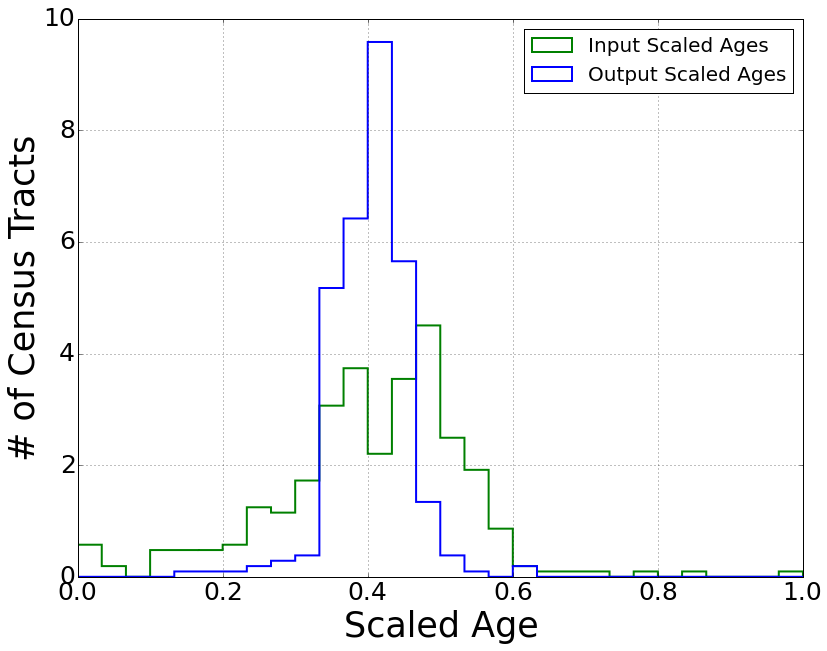

In [8]:
# make histogram of scaled ages input and output and final output (for each business/tract combo)
plt.figure(figsize=(13, 10))
plt.hist([bus_age_pred_final,features.bus_age], bins=30, histtype='step', align='mid', linewidth=2, normed=1, \
         label=['Output Scaled Ages','Input Scaled Ages'])
plt.legend(loc=0,fontsize=20)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('Scaled Age',fontsize=35)
plt.ylabel('# of Census Tracts',fontsize=35)

(313,)
0.404798903583
0.406160117829
0.0516572952231


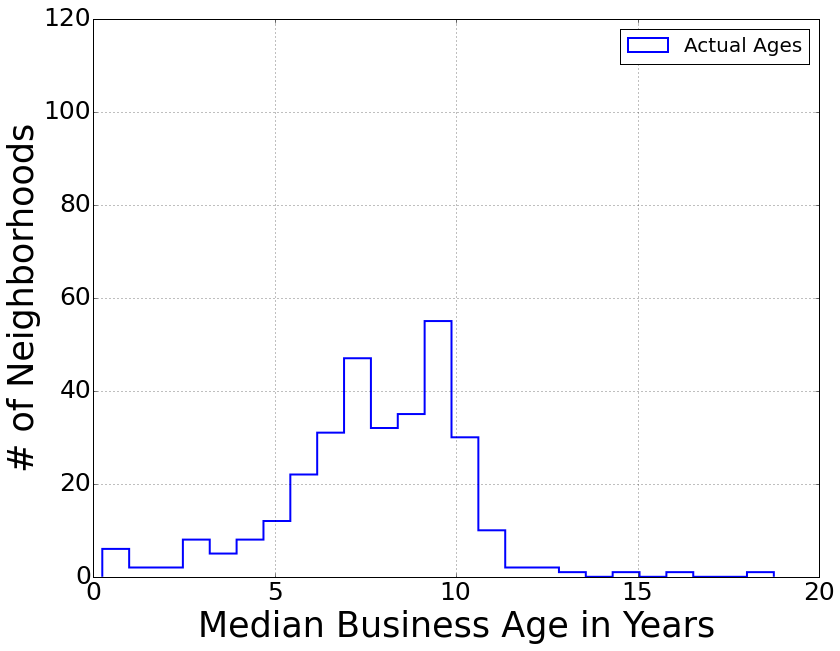

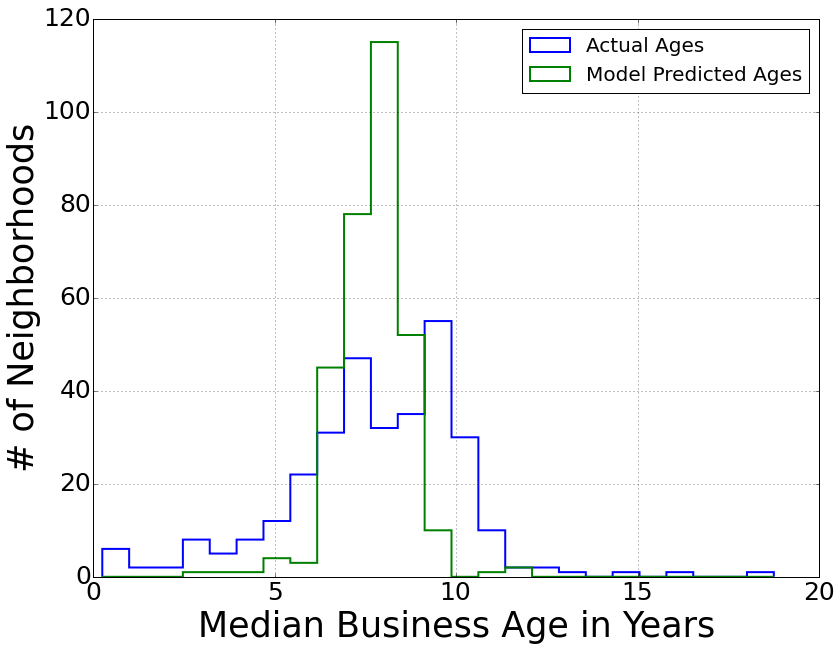

In [9]:
# unscale actual busisness ages
t1 = features.bus_age * (bus_age_max-bus_age_min) + bus_age_min
# unscale predicted busisness ages
t2 = bus_age_pred_final * (bus_age_max-bus_age_min) + bus_age_min

plt.figure(figsize=(13, 10))
plt.hist(t1, bins=25, histtype='step', align='mid', linewidth=2, \
         label=['Actual Ages'])
plt.legend(loc=0,fontsize=20)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('Median Business Age in Years',fontsize=35)
plt.ylabel('# of Neighborhoods',fontsize=35)
plt.ylim(0,120)

plt.figure(figsize=(13, 10))
plt.hist([t2,t1], bins=25, histtype='step', align='mid', linewidth=2, \
         label=['Model Predicted Ages','Actual Ages'],color='gb')
plt.legend(loc=0,fontsize=20)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('Median Business Age in Years',fontsize=35)
plt.ylabel('# of Neighborhoods',fontsize=35)
plt.ylim(0,120)

# print some stats about the model output for each tract/code combo
print bus_age_pred_final.shape
print np.mean(bus_age_pred_final)
print np.median(bus_age_pred_final)
print np.std(bus_age_pred_final)

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


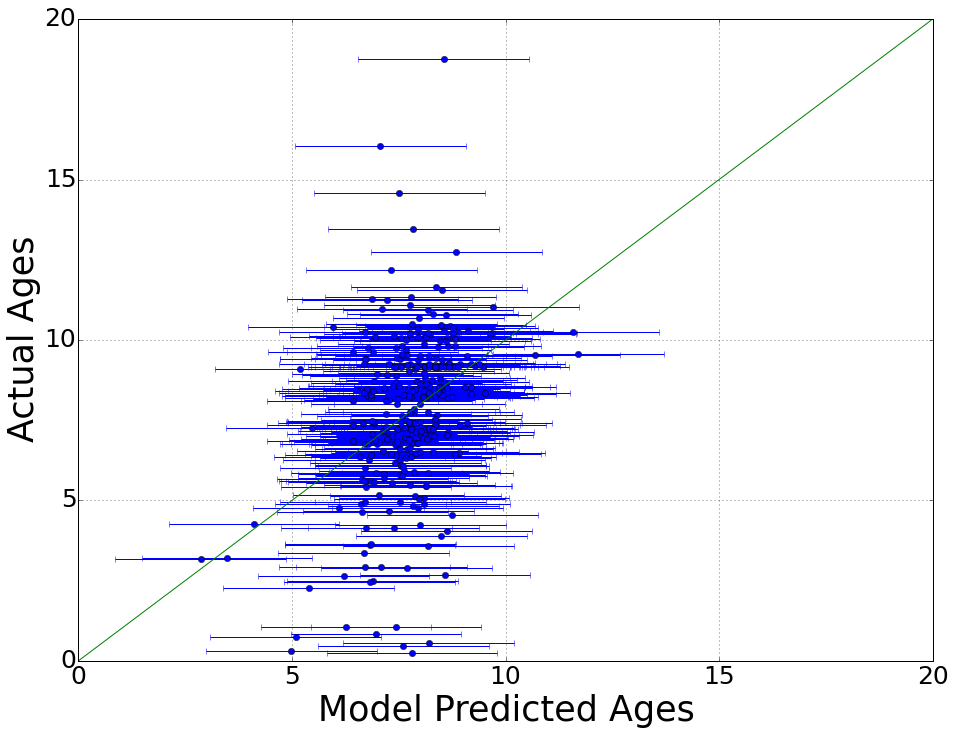

In [10]:
plt.figure(figsize=(13, 10))
#plt.scatter(t2,t1)
plt.errorbar(t2, t1, xerr=2, fmt='o')
plt.plot([0,20],[0,20])
plt.xlabel('Model Predicted Ages',fontsize=35)
plt.ylabel('Actual Ages',fontsize=35)
plt.tight_layout()
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=25)

## Save newly made lists of tract/code combos and scores and diff to dataframes

In [11]:
# scale ages to 0 to 100 to get WhereSIOUS score
print min(bus_age_pred_final)
print max(bus_age_pred_final)
score = 100 * (bus_age_pred_final-min(bus_age_pred_final)) / (max(bus_age_pred_final)-min(bus_age_pred_final))
print min(score)
print max(score)

# scale scores again with a logistic function to spread them out more evenly
score = score/(1+3/np.std(score)*np.exp(-2/np.std(score)*(score-np.mean(score))))
print min(score)
print max(score)

# save lists of tracts and final predicted ages as a dataframe
df_ages = pd.DataFrame({'census_tract': tracts_final, 'score': score})
print df_ages.shape
#print df_ages[:538]

0.141400797198
0.619021317382
0.0
100.0
0.0
99.9930655732
(313, 2)


In [ ]:
# write dataframe of tracts, codes, and scores to csv in data_final folder and in flask static folder
df_ages.to_csv('data_final/tracts_scores.csv')
df_ages.to_csv('wheresious/static/tracts_scores.csv')

## Do some heatmap plotting

In [19]:
# make new dataframe for heat map plotting
df_map = df_ages.pivot(index='census_tract', columns='code_simple', values='score')
print df_map.shape
#df_map

KeyError: 'code_simple'

In [20]:
# make new dataframe for heat map plotting
df_map_diff = df_diffs.pivot(index='census_tract', columns='code_simple', values='score')
print df_map_diff.shape
#df_map_diff

NameError: name 'df_diffs' is not defined

In [21]:
# propagate business ages for each tract through each business type
age_code_og = np.vstack([features.bus_age.values]*24).T

NameError: name 'df_map' is not defined

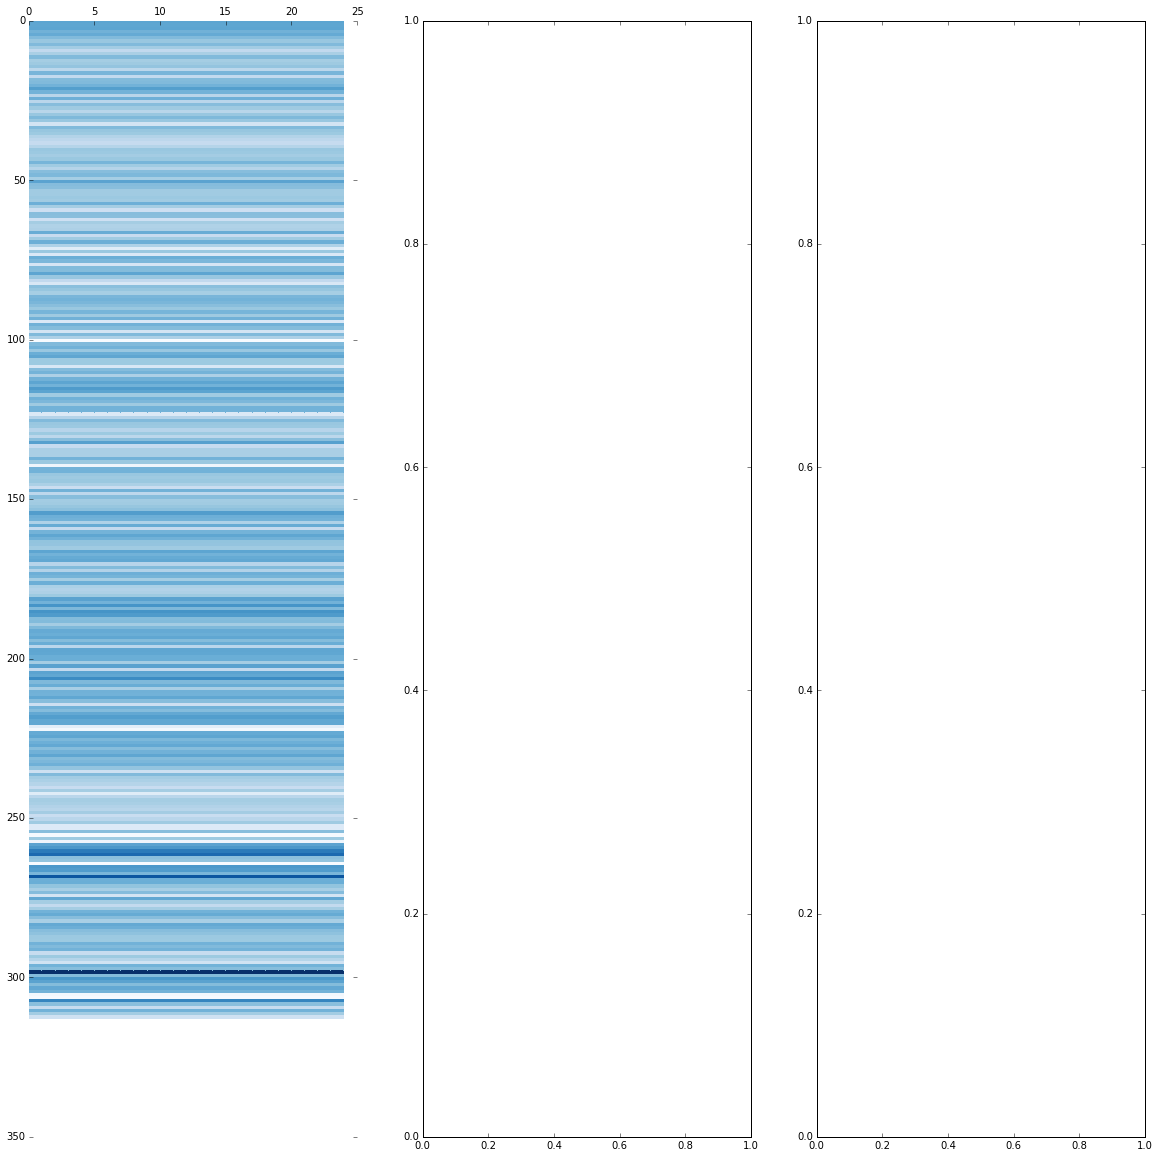

In [23]:
# make figure for heat map
fig, ax = plt.subplots(1,3)

# heat map of original business ages
heatmap = ax[0].pcolor(age_code_og,cmap=plt.cm.Blues)
# fix presentation
fig = plt.gcf()
fig.set_size_inches(20, 20)
# turn off the frame
ax[0].set_frame_on(False)
# want a more natural, table-like display
ax[0].invert_yaxis()
ax[0].xaxis.tick_top()
ax[0].grid(False)

# heat map of model output business ages for every tract/code combo
heatmap = ax[1].pcolor(df_map.values,cmap=plt.cm.Blues)
# turn off the frame
ax[1].set_frame_on(False)
# want a more natural, table-like display
ax[1].invert_yaxis()
ax[1].xaxis.tick_top()
ax[1].grid(False)

# heat map of relative diffs
heatmap = ax[2].pcolor(df_map_diff.values,cmap=plt.cm.Blues)
# turn off the frame
ax[2].set_frame_on(False)
# want a more natural, table-like display
ax[2].invert_yaxis()
ax[2].xaxis.tick_top()
ax[2].grid(False)

plt.show()

## Make a histogram and do some stats on the WhereSIOUS scores

41.6442094357
43.8851195743
19.6026699467


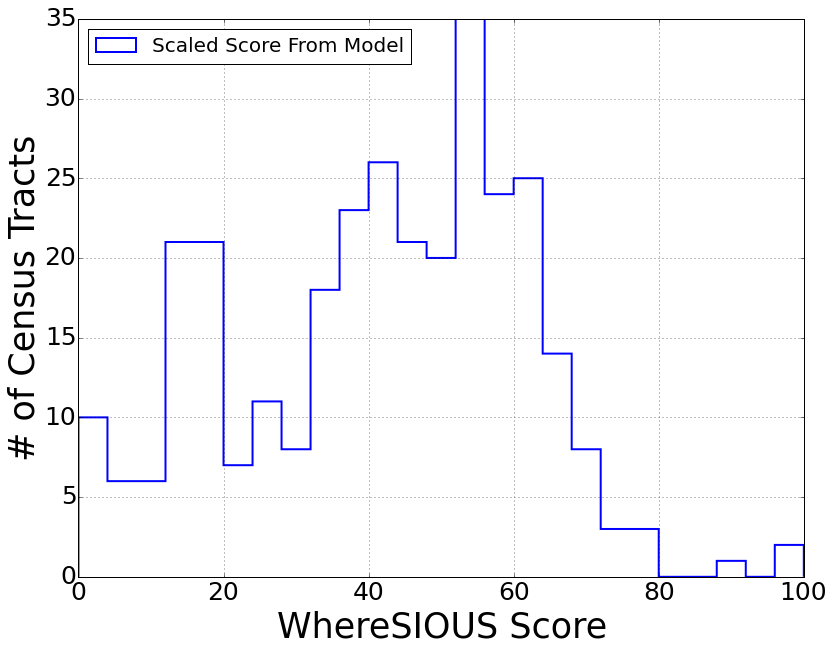

In [24]:
# make histogram of scores scaled 0 to 100
plt.figure(figsize=(13, 10))
plt.hist(df_ages.score, bins=25, histtype='step', align='mid', linewidth=2, \
         label=['Scaled Score From Model'])
plt.legend(loc=2,fontsize=20)
plt.xlim(0,100)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('WhereSIOUS Score',fontsize=35)
plt.ylabel('# of Census Tracts',fontsize=35)

# print some stats about model output
mean = np.mean(df_ages.score)
print mean
print np.median(df_ages.score)
std = np.std(df_ages.score)
print std

## Cut 3-sigma outliers maybe?

In [25]:
# shift 3-sigma outlier scores by hand
#print sum(df_scores.score<(mean-3*std))
#df_scores.score[df_scores.score<(mean-3*std)] = mean-3*std
#print sum(df_scores.score>(mean+3*std))
#df_scores.score[df_scores.score>(mean+3*std)] = mean+3*std

# make histogram of shifted diffs
#plt.figure(figsize=(13, 10))
#plt.hist(df_scores.score, bins=30, histtype='step', align='mid', linewidth=2, \
#         label=['Scaled Difference in Before and After Scores'])
#plt.legend(loc=0,fontsize=20)
#plt.grid()
#plt.tick_params(axis='both', which='major', labelsize=25)
#plt.xlabel('WhereSIOUS Score',fontsize=35)
#plt.ylabel('# of Census Tracts',fontsize=35)

# print some stats about model output
#print np.mean(df_scores.score)
#print np.median(df_scores.score)
#print np.std(df_scores.score)

In [26]:
# get max score
max_score = df_ages.score.max()
print df_ages[max_score==df_ages.score.values]
# get min score
min_score = df_ages.score.min()
print df_ages[min_score==df_ages.score.values]

     census_tract      score
192          8511  99.993066
    census_tract  score
82          3800    0.0


## Test reading from tract/code/score file

In [27]:
# test reading in dataframe of tracts, codes, and scores
temp = pd.read_csv('data_final/tracts_scores.csv',index_col=0)
print temp.shape
print temp[:10]
print temp[-10:]

# test looking up a score given a tract and code
tract = 9104
# get correct row of dataframe
score_row = temp[(temp.census_tract==tract)].score
# get score itself
score = score_row.values[0]
# format score to one decimal place
result = round(score)
print result

(313, 2)
   census_tract      score
0           100  69.634478
1           201  76.759984
2           202  61.513588
3           300  67.244049
4           400  65.568874
5           500  62.200364
6           600  58.201943
7           700  62.395632
8           800  43.885120
9           900  47.296093
     census_tract      score
303         20404  40.969705
304         20706  54.956654
305         20707  19.385639
306         20709  39.344742
307         20710  65.824784
308         21100  26.548610
309         21302   3.777012
310         21400  37.461475
311         21500  53.820297
312         21800  62.420857
62.0


## Try fitting using LASSO

In [14]:
feat = features.copy()
tract = feat.census_tract.values
feat = feat.drop('census_tract', 1)
ages = feat.bus_age.values
feat = feat.drop('bus_age', 1)
feat = feat.drop('population_percent_male',1)
feat = feat.drop('minor_percent',1)

In [15]:
#feat = feat.drop('age_med_male',1)
#feat = feat.drop('age_med_female',1)
feat = feat.drop('homes_percent_mortgage',1)
feat = feat.drop('homes_percent_clear',1)
feat = feat.drop('homes_percent_rent',1)
feat = feat.drop('income_med_owner',1)
feat = feat.drop('income_med_renter',1)
feat = feat.drop('cost_med_owner',1)
feat = feat.drop('cost_med_renter',1)
#feat = feat.drop('total_amount',1)

In [16]:
feat = feat.drop('n_businesses_11',1)
feat = feat.drop('n_businesses_21',1)
feat = feat.drop('n_businesses_22',1)
feat = feat.drop('n_businesses_23',1)
feat = feat.drop('n_businesses_31',1)
feat = feat.drop('n_businesses_32',1)
feat = feat.drop('n_businesses_33',1)
feat = feat.drop('n_businesses_42',1)
feat = feat.drop('n_businesses_44',1)
feat = feat.drop('n_businesses_45',1)
feat = feat.drop('n_businesses_48',1)
feat = feat.drop('n_businesses_49',1)
feat = feat.drop('n_businesses_51',1)
feat = feat.drop('n_businesses_52',1)
feat = feat.drop('n_businesses_53',1)
feat = feat.drop('n_businesses_54',1)
feat = feat.drop('n_businesses_55',1)
feat = feat.drop('n_businesses_56',1)
feat = feat.drop('n_businesses_61',1)
feat = feat.drop('n_businesses_62',1)
feat = feat.drop('n_businesses_71',1)
feat = feat.drop('n_businesses_72',1)
feat = feat.drop('n_businesses_81',1)
feat = feat.drop('n_businesses_92',1)
#feat = feat.drop('total_amount',1)

print tract
print ages.shape
print feat.shape
feat.values

[  100   201   202   300   400   500   600   700   800   900  1000  1100
  1200  1300  1400  1500  1600  1700  1800  1900  2001  2002  2100  2201
  2202  2301  2302  2401  2402  2501  2502  2601  2602  2702  2703  2705
  2707  2708  2709  2710  2711  2712  2801  2803  2804  2902  2903  2904
  2905  3001  3003  3004  3101  3103  3105  3107  3109  3111  3112  3113
  3114  3115  3201  3202  3208  3209  3211  3212  3213  3214  3301  3303
  3304  3305  3401  3403  3404  3501  3502  3601  3602  3603  3800  3901
  3902  4000  4100  4200  4300  4400  4501  4600  4700  4800  4900  5000
  5100  5200  5300  5400  5500  5600  5700  5800  5900  6000  6100  6200
  6300  6500  6600  6801  6802  6900  7002  7100  7200  7301  7302  7400
  7501  7502  7600  7701  7702  7800  7903  7905  7907  7908  7910  8002
  8003  8006  8101  8102  8200  8301  8303  8305  8306  8307  8310  8311
  8312  8313  8324  8327  8328  8329  8330  8331  8333  8335  8336  8337
  8339  8340  8341  8343  8344  8345  8346  8347  8

array([[  4.02439024e-02,   1.64528087e-01,   7.99777085e-01, ...,
          5.92592593e-01,   5.83333333e-01,   0.00000000e+00],
       [  5.51829268e-02,   9.44967208e-02,   8.51887538e-01, ...,
          5.92592593e-01,   5.83333333e-01,   2.17659537e-02],
       [  5.57926829e-02,   2.31765041e-01,   7.91202460e-01, ...,
          6.17283951e-01,   5.00000000e-01,   5.90469418e-02],
       ..., 
       [  1.90548780e-01,   4.03820930e-01,   7.53271222e-01, ...,
          5.43209877e-01,   7.14285714e-01,   3.82860055e-04],
       [  8.35365854e-02,   4.96264614e-01,   8.01107665e-01, ...,
          0.00000000e+00,   5.59523810e-01,   0.00000000e+00],
       [  1.34146341e-02,   1.07100086e-01,   8.37127915e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [20]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0)
clf.fit(feat.values, ages)
#print(feat.columns[abs(clf.coef_)<1.e-3])
print(feat.columns[abs(clf.coef_)>0.15])
print(clf.coef_[abs(clf.coef_)>0.15])
print
print(feat.columns)
print(clf.coef_)
print(clf.intercept_)

Index([u'n_business', u'population_percent_female', u'age_med',
       u'age_med_male', u'walk_score', u'bike_score'],
      dtype='object')
[ 0.28589703  0.19278604  0.39579849 -0.19626696  0.18924525 -0.15162743]

Index([u'n_business', u'population', u'population_percent_female', u'age_med',
       u'age_med_male', u'age_med_female', u'adult_percent', u'homes',
       u'employment_percent', u'income_med', u'cost_med', u'walk_score',
       u'transit_score', u'bike_score', u'total_amount'],
      dtype='object')
[ 0.28589703  0.01054274  0.19278604  0.39579849 -0.19626696 -0.03368161
  0.14752516 -0.01658199  0.04826123  0.12326673 -0.06417073  0.18924525
 -0.0485331  -0.15162743 -0.10794442]
0.0277628324251


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  app.launch_new_instance()


In [21]:
clf.score(feat.values, ages)

0.15513843139750916

## Try a random forest classifier (for feature selection)

In [31]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(feat.values, ages)
print(forest.feature_importances_)
print(feat.columns[forest.feature_importances_>0.3])
print(feat.columns)
print forest.score(feat.values, tract)

ValueError: Unknown label type: array([[ 0.54187629],
       [ 0.53825096],
       [ 0.54187629],
       [ 0.48609056],
       [ 0.51649896],
       [ 0.44902338],
       [ 0.38754069],
       [ 0.44643386],
       [ 0.36075762],
       [ 0.2641314 ],
       [ 0.3391536 ],
       [ 0.4478396 ],
       [ 0.35402486],
       [ 0.37200355],
       [ 0.40100621],
       [ 0.28188813],
       [ 0.46825984],
       [ 0.26065404],
       [ 0.44036697],
       [ 0.44746967],
       [ 0.48076354],
       [ 0.56880734],
       [ 0.48179935],
       [ 0.29343001],
       [ 0.49437703],
       [ 0.2858834 ],
       [ 0.43311631],
       [ 0.37377922],
       [ 0.2891388 ],
       [ 0.38724475],
       [ 0.44924534],
       [ 0.38798461],
       [ 0.18193252],
       [ 0.44569399],
       [ 0.39205386],
       [ 0.37688665],
       [ 0.31170465],
       [ 0.27996449],
       [ 0.25088784],
       [ 0.30275229],
       [ 0.38754069],
       [ 0.37940219],
       [ 0.35661438],
       [ 0.38635691],
       [ 0.4701095 ],
       [ 0.36734241],
       [ 0.30393608],
       [ 0.42971293],
       [ 0.4548683 ],
       [ 0.35039953],
       [ 0.54942291],
       [ 0.43489198],
       [ 0.42645753],
       [ 0.36386505],
       [ 0.36608464],
       [ 0.38250962],
       [ 0.36490086],
       [ 0.49541284],
       [ 0.35232317],
       [ 0.21485647],
       [ 0.43348624],
       [ 0.42734537],
       [ 0.21093519],
       [ 0.35158331],
       [ 0.31962119],
       [ 0.33182894],
       [ 0.50969222],
       [ 0.24696656],
       [ 0.37096774],
       [ 0.49659663],
       [ 0.32509618],
       [ 0.12104173],
       [ 0.38324948],
       [ 0.14493933],
       [ 0.50103581],
       [ 0.45782776],
       [ 0.16913288],
       [ 0.44362237],
       [ 0.44051495],
       [ 0.54010062],
       [ 0.38842853],
       [ 0.26531518],
       [ 0.15766499],
       [ 0.42386801],
       [ 0.39064812],
       [ 0.35143534],
       [ 0.46707606],
       [ 0.48076354],
       [ 0.46308079],
       [ 0.42912104],
       [ 0.38650488],
       [ 0.47144125],
       [ 0.37355727],
       [ 0.48668245],
       [ 0.14486534],
       [ 0.48646049],
       [ 0.43799941],
       [ 0.18341225],
       [ 0.44695176],
       [ 0.32968334],
       [ 0.00251554],
       [ 0.44880142],
       [ 0.48091151],
       [ 0.3885765 ],
       [ 0.50007399],
       [ 0.53617934],
       [ 0.37629476],
       [ 0.3777005 ],
       [ 0.15936668],
       [ 0.43711157],
       [ 0.47795206],
       [ 0.32864753],
       [ 0.48646049],
       [ 0.5396567 ],
       [ 0.48290914],
       [ 0.58301273],
       [ 0.54483575],
       [ 0.36460491],
       [ 0.48653448],
       [ 0.45797573],
       [ 0.37333531],
       [ 0.48179935],
       [ 0.48187334],
       [ 0.14234981],
       [ 0.30637763],
       [ 0.44880142],
       [ 0.38946434],
       [ 0.38029003],
       [ 0.3000148 ],
       [ 0.3788103 ],
       [ 0.28358982],
       [ 0.42912104],
       [ 0.56451613],
       [ 0.25081385],
       [ 0.33745191],
       [ 0.3391536 ],
       [ 0.33745191],
       [ 0.48076354],
       [ 0.3836934 ],
       [ 0.04306008],
       [ 0.48290914],
       [ 0.48128144],
       [ 0.38783664],
       [ 0.37178159],
       [ 0.3836934 ],
       [ 0.33419651],
       [ 0.23142942],
       [ 0.48461083],
       [ 0.28107428],
       [ 0.4309707 ],
       [ 0.36201539],
       [ 0.36697248],
       [ 0.39412548],
       [ 0.41935484],
       [ 0.57657591],
       [ 0.49356318],
       [ 0.48076354],
       [ 0.32509618],
       [ 0.51398343],
       [ 0.25443918],
       [ 0.47861793],
       [ 0.53662326],
       [ 0.48683042],
       [ 0.40618526],
       [ 0.39908257],
       [ 0.37081977],
       [ 0.53950873],
       [ 0.48179935],
       [ 0.5130216 ],
       [ 0.53092631],
       [ 0.29742527],
       [ 0.44317846],
       [ 0.31429417],
       [ 0.4951169 ],
       [ 0.47506659],
       [ 0.35180527],
       [ 0.49970405],
       [ 0.33575022],
       [ 0.31636579],
       [ 0.32983131],
       [ 0.37733057],
       [ 0.55230838],
       [ 0.48076354],
       [ 0.61046168],
       [ 0.45205682],
       [ 0.61527079],
       [ 0.58575022],
       [ 0.43799941],
       [ 0.44428825],
       [ 0.35883397],
       [ 0.45279669],
       [ 0.51627701],
       [ 0.50369932],
       [ 0.53358982],
       [ 0.4385913 ],
       [ 0.50680675],
       [ 0.28869488],
       [ 0.53773306],
       [ 0.53181415],
       [ 0.50088784],
       [ 0.5032554 ],
       [ 0.3549127 ],
       [ 0.55105061],
       [ 0.25495709],
       [ 0.54720331],
       [ 0.53063036],
       [ 0.64479136],
       [ 0.44968926],
       [ 0.50725067],
       [ 0.34300089],
       [ 0.48446286],
       [ 0.48076354],
       [ 0.53292394],
       [ 0.43060077],
       [ 0.21766795],
       [ 0.48076354],
       [ 0.43400414],
       [ 0.52522936],
       [ 0.57043504],
       [ 0.53248002],
       [ 0.53166617],
       [ 0.1097958 ],
       [ 0.02722699],
       [ 0.51701687],
       [ 0.5375111 ],
       [ 0.45605209],
       [ 0.49304528],
       [ 0.5250074 ],
       [ 0.43296833],
       [ 0.48609056],
       [ 0.53891684],
       [ 0.44066292],
       [ 0.45945546],
       [ 0.48868008],
       [ 0.40174608],
       [ 0.21115715],
       [ 0.44650784],
       [ 0.36090559],
       [ 0.33264279],
       [ 0.30171648],
       [ 0.23941995],
       [ 0.35232317],
       [ 0.11911808],
       [ 0.28884285],
       [ 0.35409885],
       [ 0.34026339],
       [ 0.31540397],
       [ 0.29416987],
       [ 0.35839006],
       [ 0.23734833],
       [ 0.28736313],
       [ 0.36815626],
       [ 0.12984611],
       [ 0.13184374],
       [ 0.42971293],
       [ 0.01598106],
       [ 0.37814442],
       [ 0.0445398 ],
       [ 0.54897899],
       [ 0.59544244],
       [ 0.71396863],
       [ 0.77404558],
       [ 0.41979876],
       [ 0.40529743],
       [ 0.        ],
       [ 0.59381474],
       [ 0.57886949],
       [ 0.46315478],
       [ 0.8538029 ],
       [ 0.49733649],
       [ 0.50096182],
       [ 0.40603729],
       [ 0.34433264],
       [ 0.43607576],
       [ 0.1804528 ],
       [ 0.52892868],
       [ 0.35284108],
       [ 0.25910033],
       [ 0.3549127 ],
       [ 0.48076354],
       [ 0.51561113],
       [ 0.43222847],
       [ 0.34329683],
       [ 0.52086416],
       [ 0.49970405],
       [ 0.43111867],
       [ 0.41136431],
       [ 0.37903226],
       [ 0.37733057],
       [ 0.48179935],
       [ 0.44791358],
       [ 0.48179935],
       [ 0.24341521],
       [ 0.37629476],
       [ 0.30341817],
       [ 0.19695176],
       [ 0.48179935],
       [ 0.43030482],
       [ 1.        ],
       [ 0.43925718],
       [ 0.59958568],
       [ 0.55297425],
       [ 0.44125481],
       [ 0.52722699],
       [ 0.48712637],
       [ 0.03196212],
       [ 0.01257769],
       [ 0.6744599 ],
       [ 0.42408997],
       [ 0.24326724],
       [ 0.48172536],
       [ 0.36090559],
       [ 0.20509026]])

## Learning Curve

In [32]:
from sklearn import cross_validation
from sklearn.learning_curve import learning_curve

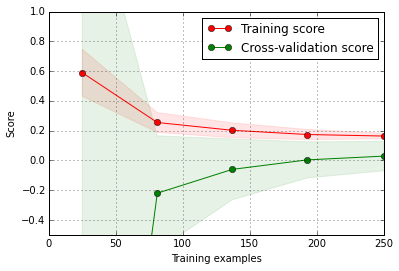

[ -4.00210280e+00  -2.20289124e-01  -6.03621835e-02   3.43155365e-03
   2.87452725e-02]


In [33]:
cv = cross_validation.ShuffleSplit(len(feat), n_iter=100, test_size=0.2)

estimator = linear_model.LinearRegression()

plt.figure()
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim((-.5,1))
train_sizes, train_scores, test_scores = learning_curve(estimator, feat.values, ages, \
                                                        cv=cv, train_sizes=np.linspace(.1, 1.0, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,\
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, \
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
plt.legend(loc="best")
plt.show()
print test_scores_mean

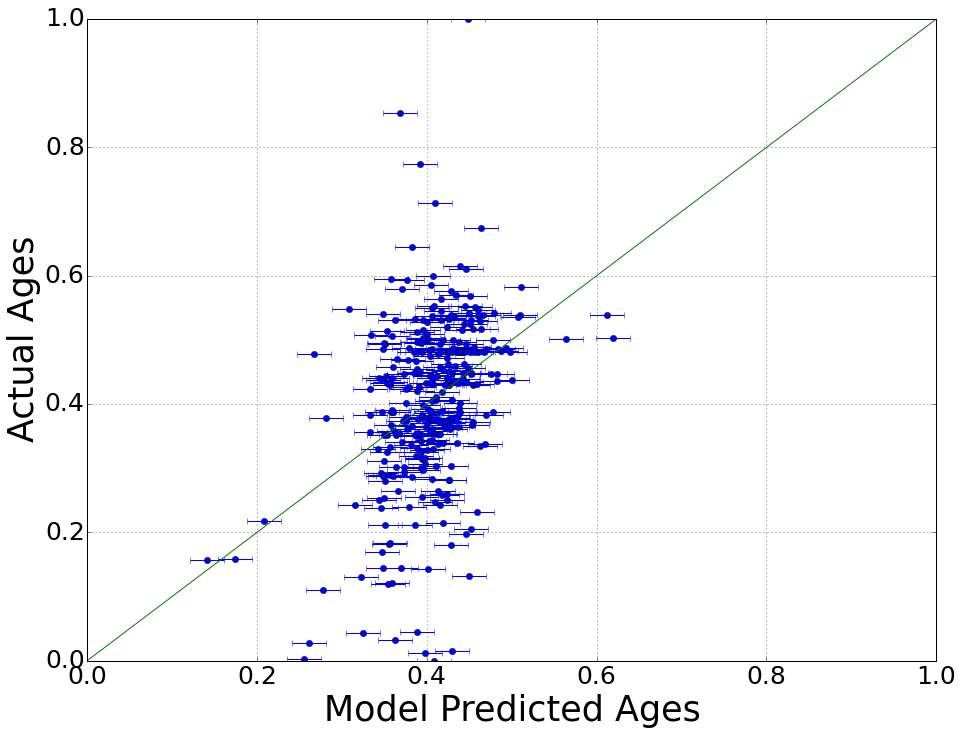

In [34]:
plt.figure(figsize=(13, 10))
plt.errorbar(clf.predict(feat.values), ages, xerr=.02, fmt='o')
plt.plot([0,1],[0,1])
plt.xlabel('Model Predicted Ages',fontsize=35)
plt.ylabel('Actual Ages',fontsize=35)
plt.tight_layout()
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=25)